# Delineate Watershed and Reclassify NLCD and Soil Map

This notebook edits and finalizes BBGC model inputs using [GRASS GIS](https://grass.osgeo.org/), [R](https://www.r-project.org), and [pyrhessys](https://github.com/DavidChoi76/pyrhessys). Specifically, all GIS files previously downloaded will be clipped to the extent of the AOI and aligned with each other so all cells line up between files.

## Set the Project Directory and Check Data

<div class="alert alert-block alert-danger">
<b> Project Name Setting: </b> Please set the Project Name for your project </div>

In [1]:
# CHANGE PROJECT NAME HERE
PROJECT_NAME = 'Test'

# CURRENT DIRECTORY HERE, SET WHERE THE NOTEBOOKS ARE LOCATED
CURRENT_DIRECTORY = '/home/teaganbaiotto/Documents/bbgci'

# SET THE SPATIAL RESOLUTION (in meters)
SPATIAL_RESOLUTION = 30

In [2]:
import os, shutil
import pyrhessys as pr
import pyproj

os.chdir(CURRENT_DIRECTORY)

In [3]:
# Define folder paths as global variables
PROJECT_DIR = os.path.join(CURRENT_DIRECTORY, PROJECT_NAME)
RAWGIS_DIR = os.path.join(PROJECT_DIR, "gis_data")
RAWOBS_DIR = os.path.join(PROJECT_DIR, "obs")
RAWSOIL_DIR = os.path.join(RAWGIS_DIR, "soil")
MODEL_DIR = os.path.join(PROJECT_DIR, 'model')
DEF_DIR = os.path.join(MODEL_DIR, 'defs')
INI_DIR = os.path.join(MODEL_DIR, 'ini_files')
EPC_DIR = os.path.join(MODEL_DIR, 'epc_files')
OUTPUT_DIR = os.path.join(MODEL_DIR, 'output')
CO2_DIR = os.path.join(MODEL_DIR, 'co2')
NDEP_DIR = os.path.join(MODEL_DIR, 'ndep')
ENDPOINT_DIR = os.path.join(MODEL_DIR, 'endpoint_files')
SPINUP_DIR = os.path.join(MODEL_DIR, 'spinup')
NORMAL_DIR = os.path.join(MODEL_DIR, 'normal')
MODEL_RAST_DIR = os.path.join(MODEL_DIR, 'raster_inputs')
IMAGE = os.path.join(PROJECT_DIR, 'image_map')

## Check Raw GIS Data and Set Paths
> #### Check raw gis data in `RAWGIS_DIR (gis_data folder)` which downloaded from HydroShare

In [4]:
raw_data_dir = os.listdir(RAWGIS_DIR)
raw_data_dir

['soil_reprojected.shp',
 'AOI_reprojected.shp',
 'soil_reprojected.cpg',
 'AOI.shp',
 'AOI.dbf',
 'AOI_reprojected.cpg',
 '__MACOSX',
 '.ipynb_checkpoints',
 'AOI_reprojected.prj',
 'soil_reprojected.dbf',
 'soil_reprojected.prj',
 'dem_reprojected.tif',
 'AOI.cpg',
 'daymet_cell.tif',
 'AOI_reprojected.dbf',
 'soil',
 'soil.zip',
 'AOI_reprojected.shx',
 'AOI.fix',
 'nlcd_reprojected.tif',
 'AOI.shx',
 'nlcd.tif',
 'AOI.prj',
 'soil_reprojected.shx',
 'nasa_dem.tif']

<div class="alert alert-block alert-danger">
<b> Please change the name of specific gis files and time series data like you named raw data. </b>  </div>

In [6]:
# Set paths to GIS data. Need to change file names if not downloaded from geoserver

rawdem = os.path.join(RAWGIS_DIR, 'dem_reprojected.tif')
landcover = os.path.join(RAWGIS_DIR, 'nlcd_reprojected.tif')
ssurgo_dir = os.path.join(RAWGIS_DIR, 'soil')
aoi_file = os.path.join(RAWGIS_DIR, 'AOI_reprojected.shp')
daymet_cell = os.path.join(RAWGIS_DIR, 'daymet_cell.tif')

## Set up GRASS Dataset and Initialize GRASS
> #### This notebook was tested on `GRASS GIS 7.8`.
<br>
To start to use GRASS GIS and Python library of GRASS GIS, we need to set GRASS database and environment.

In [7]:
import sys
import subprocess
# Set the directory to store preprocessing GRASS database
GRASS_DATA = "grass_dataset"
GISDBASE = os.path.join(PROJECT_DIR, GRASS_DATA)
# Set the full path to GRASS execution
GRASSEXE = "/usr/lib/grass78" 
# Set the command to start GRASS from shell
GRASS7BIN = "grass" 


# Define and create grass data folder, location, and mapset
if not os.path.exists(GISDBASE):
    os.mkdir(GISDBASE)
LOCATION = os.path.join(GISDBASE, PROJECT_NAME)
# Define mapset name which is a working directory for GRASS GIS
MAPSET = "PERMANENT"

# Set GISBASE environment variable
os.environ['GISBASE'] = GRASSEXE
# The following not needed with trunk
os.environ['PATH'] += os.pathsep + os.path.join(GRASSEXE, 'bin')
# Set GISDBASE environment variable
os.environ['GISDBASE'] = GISDBASE

In [8]:
# define GRASS-Python environment
gpydir = os.path.join(GRASSEXE, "etc", "python")
sys.path.append(gpydir)

# import GRASS Python library
import grass.script as gscript
import grass.script.setup as gsetup
gscript.core.set_raise_on_error(True)

False

> #### Launch GRASS session

In [9]:
gsetup.init(GRASSEXE, GISDBASE, LOCATION, MAPSET)

'/tmp/tmp4m9w6rpx'

> #### Set Projection, DO NOT CHANGE

In [10]:
# Set projection, DO NOT CHANGE

proj4="+proj=lcc +ellps=WGS84 +a=6378137 +b=6356752.314245 +lat_1=25 +lat_2=60 +lon_0=-100 +lat_0=42.5 +x_0=0 +y_0=0 +units=m +no_defs"

In [11]:
location_path = os.path.join(GISDBASE, LOCATION)
# Create GRASS database for the project
if not os.path.exists(location_path):
    startcmd = GRASS7BIN + ' -c ' + aoi_file + ' -e ' + location_path
    print(startcmd)
    p = subprocess.Popen(startcmd, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    out, err = p.communicate()
    print(p.returncode)
    if p.returncode != 0:
        print >> sys.stderr, 'ERROR: %s' % err
        print >> sys.stderr, 'ERROR: Cannot generate location (%s)' % startcmd
        sys.exit(-1)

In [12]:
from IPython.display import Image

# Default font displays
os.environ['GRASS_FONT'] = 'sans'
# Overwrite existing maps
os.environ['GRASS_OVERWRITE'] = '1'
os.environ['GRASS_RENDER_IMMEDIATE'] = 'cairo'
os.environ['GRASS_RENDER_FILE_READ'] = 'TRUE'
os.environ['GRASS_LEGEND_FILE'] = 'legend.txt'
# Create directories if directories are not previously setup.
if not os.path.exists(IMAGE):
    os.mkdir(IMAGE)
else:
    pass

> #### `g.proj` to check projection information and make sure it is in accordance with proj4 string listed above

In [13]:
!grass78 {LOCATION}/{MAPSET} --exec g.proj -p

Starting GRASS GIS...
Cleaning up temporary files...
Executing <g.proj -p> ...
-PROJ_INFO-------------------------------------------------
name       : Lambert_Conformal_Conic
ellps      : wgs84
proj       : lcc
lat_0      : 42.5
lon_0      : -100
lat_1      : 25
lat_2      : 60
x_0        : 0
y_0        : 0
no_defs    : defined
-PROJ_UNITS------------------------------------------------
unit       : meter
units      : meters
meters     : 1
Execution of <g.proj -p> finished.
Cleaning up temporary files...


## Import and Process DEM 

> #### `r.in.gdal` to import raster data into a GRASS raster map using GDAL library.
> Create **`demRAW`** GRASS raster map using DEM TIF file in **`elevationRAW`** grass_dataset directory 

In [14]:
# Create path for Elevation if does not exist
elevationRAW = "elevationRAW"
if os.path.exists(os.path.join(GISDBASE, elevationRAW)):
    shutil.rmtree(os.path.join(GISDBASE, elevationRAW))
!grass78 {LOCATION}/{MAPSET} --exec r.in.gdal -e --overwrite input={rawdem} output=demRAW location={elevationRAW}

Starting GRASS GIS...
Cleaning up temporary files...
Executing <r.in.gdal -e --overwrite input=/home/teaganbaiotto/Documents/bbgci/Test/gis_data/dem_reprojected.tif output=demRAW location=elevationRAW> ...
Location <elevationRAW> created
Importing raster map <demRAW>...
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100
Default region for this location updated
Region for the current mapset updated
Execution of <r.in.gdal -e --overwrite input=/home/teaganbaiotto/Documents/bbgci/Test/gis_data/dem_reprojected.tif output=demRAW location=elevationRAW> finished.
Cleaning up temporary files...


> #### `r.info` to show outputs basic information about a raster map
> Check current DEM information (Resolution)

In [15]:
LOCATIONDEM=GISDBASE+'/'+'elevationRAW'
!grass78 {LOCATIONDEM}/{MAPSET} --exec r.info -g map=demRAW

Starting GRASS GIS...
Cleaning up temporary files...
Executing <r.info -g map=demRAW> ...
north=-146479.25028246
south=-150561.4460157
east=1802856.71024753
west=1798749.6230769
nsres=24.8914373978048
ewres=24.8914373977575
rows=164
cols=165
cells=27060
datatype=CELL
ncats=0
Execution of <r.info -g map=demRAW> finished.
Cleaning up temporary files...


<div class="alert alert-block alert-info">
<b>Map:</b> Raw DEM Map</div>

Starting GRASS GIS...
Cleaning up temporary files...
Executing <d.rast map=demRAW> ...
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100
Execution of <d.rast map=demRAW> finished.
Cleaning up temporary files...
Starting GRASS GIS...
Cleaning up temporary files...
Executing <d.legend raster=demRAW fontsize=15 title=demRAW title_fontsize=12> ...
Forcing a smooth legend: too many categories for current window height
Execution of <d.legend raster=demRAW fontsize=15 title=demRAW title_fontsize=12> finished.
Cleaning up temporary files...


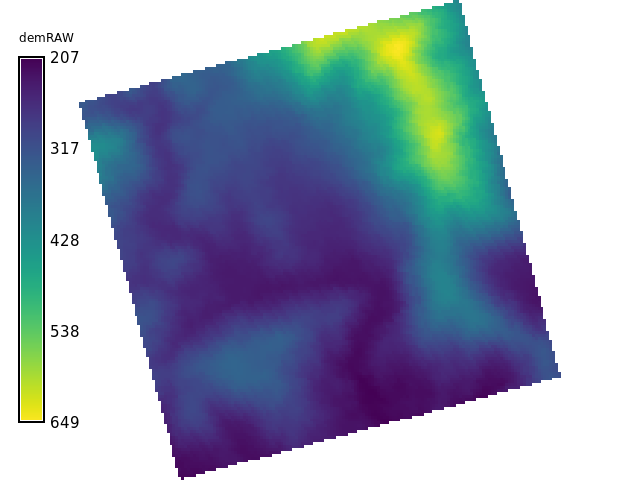

In [16]:
os.environ['GRASS_RENDER_FILE'] = 'demRAW.png'
!grass78 {LOCATIONDEM}/{MAPSET} --exec d.rast map="demRAW"
!grass78 {LOCATIONDEM}/{MAPSET} --exec d.legend raster="demRAW" fontsize='15' title='demRAW' title_fontsize='12'
shutil.copy(os.path.join(CURRENT_DIRECTORY,'demRAW.png'), os.path.join(PROJECT_DIR,'image_map'))
os.remove('demRAW.png')
image = os.path.join(PROJECT_DIR,'image_map','demRAW.png')
Image(filename=image)

> #### `r.resamp.stats` to resample and alter resolution of layer
> Change the resolution of raster map

In [17]:
!grass78 {LOCATIONDEM}/{MAPSET} --exec g.region raster=demRAW res={SPATIAL_RESOLUTION} -ap
!grass78 {LOCATIONDEM}/{MAPSET} --exec r.resamp.stats -w input=demRAW output=dem$SPATIAL_RESOLUTION'm'

Starting GRASS GIS...
Cleaning up temporary files...
Executing <g.region raster=demRAW res=30 -ap> ...
projection: 99 (unknown)
zone:       0
datum:      ** unknown (default: WGS84) **
ellipsoid:  wgs84
north:      -146460
south:      -150570
west:       1798740
east:       1802880
nsres:      30
ewres:      30
rows:       137
cols:       138
cells:      18906
Execution of <g.region raster=demRAW res=30 -ap> finished.
Cleaning up temporary files...
Starting GRASS GIS...
Cleaning up temporary files...
Executing <r.resamp.stats -w input=demRAW output=dem30m> ...
   0   5  10  15  20  25  30  35  40  45  50  55  60  65  70  75  80  85  90  95 100
Execution of <r.resamp.stats -w input=demRAW output=dem30m> finished.
Cleaning up temporary files...


<div class="alert alert-block alert-info">
<b>Map:</b> Resampled DEM</div>

Starting GRASS GIS...
Cleaning up temporary files...
Executing <d.rast map=dem30m> ...
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100
Execution of <d.rast map=dem30m> finished.
Cleaning up temporary files...
Starting GRASS GIS...
Cleaning up temporary files...
Executing <d.legend raster=dem30m fontsize=15 title=dem30m title_fontsize=12> ...
Execution of <d.legend raster=dem30m fontsize=15 title=dem30m title_fontsize=12> finished.
Cleaning up temporary files...


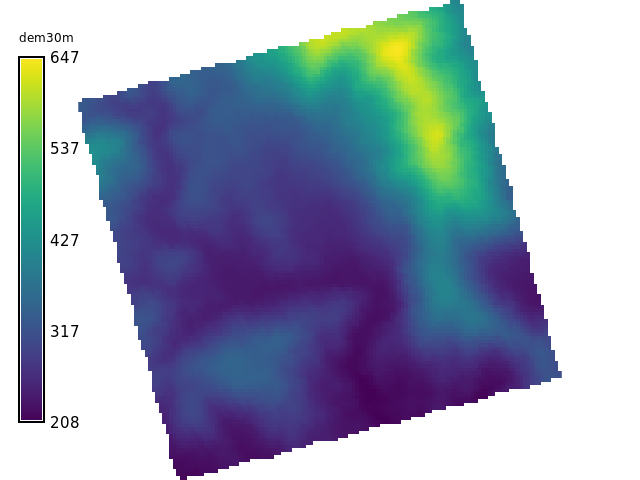

In [18]:
os.environ['GRASS_RENDER_FILE'] = 'dem'+str(SPATIAL_RESOLUTION)+'m.png'
!grass78 {LOCATIONDEM}/{MAPSET} --exec d.rast map='dem'{SPATIAL_RESOLUTION}'m'
!grass78 {LOCATIONDEM}/{MAPSET} --exec d.legend raster='dem'{SPATIAL_RESOLUTION}'m' fontsize='15' title='dem'{SPATIAL_RESOLUTION}'m' title_fontsize='12'
shutil.copy(os.path.join(CURRENT_DIRECTORY,'dem'+str(SPATIAL_RESOLUTION)+'m.png'), os.path.join(PROJECT_DIR,'image_map'))
os.remove('dem'+str(SPATIAL_RESOLUTION)+'m.png')
image = os.path.join(PROJECT_DIR,'image_map','dem'+str(SPATIAL_RESOLUTION)+'m.png')
Image(filename=image)

> #### `r.out.gdal` to export GRASS raster maps into GDAL supported format, prepares for import into main GRASS location
> "ERROR 6: SetColorInterpretation() not supported for this dataset.": This may indicate that the color table was not written properly. This is not a problem; please ignore.

In [19]:
!grass78 {LOCATIONDEM}/{MAPSET} --exec r.out.gdal --overwrite input=dem$SPATIAL_RESOLUTION'm' output=dem$SPATIAL_RESOLUTION'm.tif' format=GTiff

Starting GRASS GIS...
Cleaning up temporary files...
Executing <r.out.gdal --overwrite input=dem30m output=dem30m.tif format=GTiff> ...
Checking GDAL data type and nodata value...
   2   5   8  11  14  17  20  23  26  29  32  35  38  41  44  47  50  53  56  59  62  65  68  71  74  77  80  83  86  89  92  95  98 100
Using GDAL data type <Float64>
Input raster map contains cells with NULL-value (no-data). The value -nan
will be used to represent no-data values in the input map. You can specify
a nodata value with the nodata option.
Exporting raster data to GTiff format...
ERROR 6: SetColorTable() only supported for Byte or UInt16 bands in TIFF format.
   2   5   8  11  14  17  20  23  26  29  32  35  38  41  44  47  50  53  56  59  62  65  68  71  74  77  80  83  86  89  92  95  98 100
r.out.gdal complete. File <dem30m.tif> created.
Execution of <r.out.gdal --overwrite input=dem30m output=dem30m.tif format=GTiff> finished.
Cleaning up temporary files...


> #### `r.in.gdal` to import dem raster data into primary GRASS directory using GDAL library

In [20]:
!grass78 {LOCATION}/{MAPSET} --exec r.in.gdal -o -e --overwrite input=dem$SPATIAL_RESOLUTION'm.tif' output=dem

Starting GRASS GIS...
Cleaning up temporary files...
Executing <r.in.gdal -o -e --overwrite input=dem30m.tif output=dem> ...
Over-riding projection check
Importing raster map <dem>...
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100
Default region for this location updated
Region for the current mapset updated
Execution of <r.in.gdal -o -e --overwrite input=dem30m.tif output=dem> finished.
Cleaning up temporary files...


> #### `r.info` to check extent and # rows/columns

In [21]:
!grass78 {LOCATION}/{MAPSET} --exec r.info -g map=dem

Starting GRASS GIS...
Cleaning up temporary files...
Executing <r.info -g map=dem> ...
north=-146460
south=-150570
east=1802880
west=1798740
nsres=30
ewres=30
rows=137
cols=138
cells=18906
datatype=DCELL
ncats=0
Execution of <r.info -g map=dem> finished.
Cleaning up temporary files...


> #### `r.region` to manages the boundary definitions for the geographic region

In [22]:
!grass78 {LOCATION}/{MAPSET} --exec g.region raster=dem zoom=dem

Starting GRASS GIS...
Cleaning up temporary files...
Executing <g.region raster=dem zoom=dem> ...
Execution of <g.region raster=dem zoom=dem> finished.
Cleaning up temporary files...


> #### `v.import` to import polygon shapefile specifying model area of interest (AOI)

In [23]:
!grass78 {LOCATION}/{MAPSET} --exec v.import input={aoi_file} output=geometry --overwrite

Starting GRASS GIS...
Cleaning up temporary files...
Executing <v.import input=/home/teaganbaiotto/Documents/bbgci/Test/gis_data/AOI_reprojected.shp output=geometry --overwrite> ...
Check if OGR layer <AOI_reprojected> contains polygons...
   0 100
Creating attribute table for layer <AOI_reprojected>...
Importing 1 features (OGR layer <AOI_reprojected>)...
   0 100
-----------------------------------------------------
Registering primitives...
-----------------------------------------------------
Cleaning polygons
-----------------------------------------------------
Breaking polygons...
Breaking polygons (pass 1: select break points)...
 100
Breaking polygons (pass 2: break at selected points)...
 100
-----------------------------------------------------
Removing duplicates...
 100
-----------------------------------------------------
Breaking boundaries...
   0 100
-----------------------------------------------------
Removing duplicates...
 100
--------------------------------------

> #### `r.mask` and `g.region` to mask DEM to AOI

> Here, we also output a GRASS region definition file (grass_region) to be used for all future region setting

In [24]:
!grass78 {LOCATION}/{MAPSET} --exec r.mask vector=geometry
!grass78 {LOCATION}/{MAPSET} --exec g.region vector=geometry zoom=dem
!grass78 {LOCATION}/{MAPSET} --exec g.region raster=dem zoom=dem -p save=grass_region

Starting GRASS GIS...
Cleaning up temporary files...
Executing <r.mask vector=geometry> ...
Reading areas...
   0 100
Writing raster map...
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100
All subsequent raster operations will be limited to the MASK area. Removing
or renaming raster map named 'MASK' will restore raster operations to
normal.
Execution of <r.mask vector=geometry> finished.
Cleaning up default sqlite database ...
Cleaning up temporary files...
Starting GRASS GIS...
Cleaning up temporary files...
Executing <g.region vector=geometry zoom=dem> ...
Execution of <g.region vector=geometry zoom=dem> finished.
Cleaning up default sqlite database ...
Cleaning up temporary files...
Starting GRASS GIS...
Cleaning up temporary files...
Executing <g.region raster=dem zoom=dem -p save=grass_region> ...
projection: 99 (Lambert_Conformal_Conic)
zone:       0
datum:      ** unknown (default: WGS84)

<div class="alert alert-block alert-info">
<b>Map:</b> DEM and AOI</div>

Starting GRASS GIS...
Cleaning up temporary files...
Executing <d.rast map=dem> ...
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  43  46  49  52  55  58  61  64  67  70  73  76  79  82  86  89  92  95  98 100
Execution of <d.rast map=dem> finished.
Cleaning up default sqlite database ...
Cleaning up temporary files...
Starting GRASS GIS...
Cleaning up temporary files...
Executing <d.vect map=geometry type=boundary color=red> ...
d.vect complete.
Execution of <d.vect map=geometry type=boundary color=red> finished.
Cleaning up default sqlite database ...
Cleaning up temporary files...
Starting GRASS GIS...
Cleaning up temporary files...
Executing <d.legend raster=dem fontsize=15 title=dem title_fontsize=12> ...
Execution of <d.legend raster=dem fontsize=15 title=dem title_fontsize=12> finished.
Cleaning up default sqlite database ...
Cleaning up temporary files...


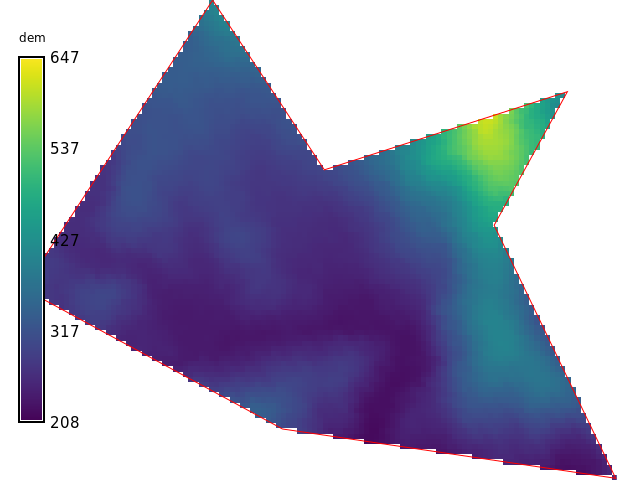

In [25]:
os.environ['GRASS_RENDER_FILE'] = 'dem.png'
!grass78 {LOCATION}/{MAPSET} --exec d.rast map="dem"
!grass78 {LOCATION}/{MAPSET} --exec d.vect map="geometry" type="boundary" color="red"
!grass78 {LOCATION}/{MAPSET} --exec d.legend raster="dem" fontsize='15' title='dem' title_fontsize='12'
shutil.copy(os.path.join(CURRENT_DIRECTORY,'dem.png'), os.path.join(PROJECT_DIR,'image_map'))
os.remove('dem.png')
image = os.path.join(PROJECT_DIR,'image_map','dem.png')
Image(filename=image)

## Output DEM as ASCII Raster

In [26]:
!grass78 {LOCATION}/{MAPSET} --exec r.out.ascii --overwrite input="dem" output={MODEL_RAST_DIR}/dem.txt precision=2

Starting GRASS GIS...
Cleaning up temporary files...
Executing <r.out.ascii --overwrite input=dem output=/home/teaganbaiotto/Documents/bbgci/Test/model/raster_inputs/dem.txt precision=2> ...
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  43  46  49  52  55  58  61  64  67  70  73  76  79  82  86  89  92  95  98Execution of <r.out.ascii --overwrite input=dem output=/home/teaganbaiotto/Documents/bbgci/Test/model/raster_inputs/dem.txt precision=2> finished.
Cleaning up default sqlite database ...
Cleaning up temporary files...


## Extract Soil properties from SSURGO database

> #### `v.in.ogr` to Import vector data into a GRASS vector map using OGR library

In [27]:
# Import Shapefile of SSURGO soil data
soilRAW = "soilRAW"
LOCATIONSOIL=GISDBASE+'/'+'soilRAW'
if os.path.exists(os.path.join(GISDBASE, soilRAW)):
    shutil.rmtree(os.path.join(GISDBASE, soilRAW))
!grass78 {LOCATION}/{MAPSET} --exec v.in.ogr input={os.path.join(RAWGIS_DIR,'soil_reprojected.shp')} output=ssurgoRAW location={soilRAW}

Starting GRASS GIS...
Cleaning up temporary files...
Executing <v.in.ogr input=/home/teaganbaiotto/Documents/bbgci/Test/gis_data/soil_reprojected.shp output=ssurgoRAW location=soilRAW> ...
Location <soilRAW> created
Check if OGR layer <soil_reprojected> contains polygons...
   0   2   4   6   8  10  12  14  16  18  20  22  24  26  28  30  32  34  36  38  40  42  44  46  48  50  52  54  56  58  60  62  64  66  68  70  72  74  76  78  80  82  84  86  88  90  92  94  96  98 100
Creating attribute table for layer <soil_reprojected>...
Importing 102 features (OGR layer <soil_reprojected>)...
   0   2   4   6   8  10  12  14  16  18  20  22  24  26  28  30  32  34  36  38  40  42  44  46  48  50  52  54  56  58  60  62  64  66  68  70  72  74  76  78  80  82  84  86  88  90  92  94  96  98 100
-----------------------------------------------------
Registering primitives...
-----------------------------------------------------
Cleaning polygons
-------------------------------------------------

> #### `g.region` to manage region definitions (extent, cellsize, etc.) in raw soil directory

In [28]:
if not os.path.exists(os.path.join(LOCATIONSOIL, 'PERMANENT', 'windows')):
    os.makedirs(os.path.join(LOCATIONSOIL, 'PERMANENT', 'windows'))
shutil.copyfile(os.path.join(LOCATION, 'PERMANENT', 'windows', 'grass_region'), os.path.join(LOCATIONSOIL, 'PERMANENT', 'windows', 'grass_region'))

!grass78 {LOCATIONSOIL}/{MAPSET} --exec g.region region=grass_region -p

Starting GRASS GIS...
Cleaning up temporary files...
Executing <g.region region=grass_region -p> ...
projection: 99 (Lambert_Conformal_Conic)
zone:       0
datum:      ** unknown (default: WGS84) **
ellipsoid:  wgs84
north:      -146970
south:      -149760
west:       1799100
east:       1802550
nsres:      30
ewres:      30
rows:       93
cols:       115
cells:      10695
Execution of <g.region region=grass_region -p> finished.
Cleaning up default sqlite database ...
Cleaning up temporary files...


> #### `v.db.addcolumn` to add attribute to soil map of MUKEY in integer form

In [29]:
!grass78 {LOCATIONSOIL}/{MAPSET} --exec v.db.addcolumn map=ssurgoRAW column="mukeyint INT"
!grass78 {LOCATIONSOIL}/{MAPSET} --exec db.execute sql="UPDATE ssurgoRAW SET mukeyint=MUKEY"

Starting GRASS GIS...
Cleaning up temporary files...
Executing <v.db.addcolumn map=ssurgoRAW column=mukeyint INT> ...
Execution of <v.db.addcolumn map=ssurgoRAW column=mukeyint INT> finished.
Cleaning up default sqlite database ...
Cleaning up temporary files...
Starting GRASS GIS...
Cleaning up temporary files...
Executing <db.execute sql=UPDATE ssurgoRAW SET mukeyint=MUKEY> ...
Execution of <db.execute sql=UPDATE ssurgoRAW SET mukeyint=MUKEY> finished.
Cleaning up default sqlite database ...
Cleaning up temporary files...


> #### `v.to.rast` to generate soil MUKEY raster

In [30]:
# Convert polygon shapefile to raster
!grass78 {LOCATIONSOIL}/{MAPSET} --exec v.to.rast --overwrite input=ssurgoRAW type=area output=ssurgo use=attr attribute_column=mukeyint

Starting GRASS GIS...
Cleaning up temporary files...
Executing <v.to.rast --overwrite input=ssurgoRAW type=area output=ssurgo use=attr attribute_column=mukeyint> ...
Reading areas...
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100
Writing raster map...
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  43  46  49  52  55  58  61  64  67  70  73  76  79  82  86  89  92  95  98 100
v.to.rast complete.
Execution of <v.to.rast --overwrite input=ssurgoRAW type=area output=ssurgo use=attr attribute_column=mukeyint> finished.
Cleaning up default sqlite database ...
Cleaning up temporary files...


> #### `r.out.gdal` to export raster map and prepare for import into primary GRASS directory

In [31]:
!grass78 {LOCATIONSOIL}/{MAPSET} --exec r.out.gdal --overwrite input=ssurgo output='ssurgo.tif' format=GTiff

Starting GRASS GIS...
Cleaning up temporary files...
Executing <r.out.gdal --overwrite input=ssurgo output=ssurgo.tif format=GTiff> ...
Checking GDAL data type and nodata value...
   2   5   8  11  15  18  21  24  27  30  33  36  39  43  46  49  52  55  58  61  64  67  70  73  76  79  82  86  89  92  95  98 100
Using GDAL data type <Int32>
Input raster map contains cells with NULL-value (no-data). The value
-2147483648 will be used to represent no-data values in the input map. You
can specify a nodata value with the nodata option.
Exporting raster data to GTiff format...
ERROR 6: SetColorTable() only supported for Byte or UInt16 bands in TIFF format.
   2   5   8  11  15  18  21  24  27  30  33  36  39  43  46  49  52  55  58  61  64  67  70  73  76  79  82  86  89  92  95  98 100
r.out.gdal complete. File <ssurgo.tif> created.
Execution of <r.out.gdal --overwrite input=ssurgo output=ssurgo.tif format=GTiff> finished.
Cleaning up default sqlite database ...
Cleaning up temporary files

> #### `r.in.gdal` to load ssurgo into main GRASS location

In [32]:
!grass78 {LOCATION}/{MAPSET} --exec r.in.gdal -o -e --overwrite input='ssurgo.tif' output=ssurgo

Starting GRASS GIS...
Cleaning up temporary files...
Executing <r.in.gdal -o -e --overwrite input=ssurgo.tif output=ssurgo> ...
Over-riding projection check
Importing raster map <ssurgo>...
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  43  46  49  52  55  58  61  64  67  70  73  76  79  82  86  89  92  95  98 100
Default region for this location updated
Region for the current mapset updated
Execution of <r.in.gdal -o -e --overwrite input=ssurgo.tif output=ssurgo> finished.
Cleaning up default sqlite database ...
Cleaning up temporary files...


> #### `g.region` to manage region definitions (extent, cellsize, etc.)

In [33]:
!grass78 {LOCATION}/{MAPSET} --exec g.region region=grass_region -p

Starting GRASS GIS...
Cleaning up temporary files...
Executing <g.region region=grass_region -p> ...
projection: 99 (Lambert_Conformal_Conic)
zone:       0
datum:      ** unknown (default: WGS84) **
ellipsoid:  wgs84
north:      -146970
south:      -149760
west:       1799100
east:       1802550
nsres:      30
ewres:      30
rows:       93
cols:       115
cells:      10695
Execution of <g.region region=grass_region -p> finished.
Cleaning up default sqlite database ...
Cleaning up temporary files...


> #### `r.to.vect` to vectorize soil raster in main GRASS location

In [34]:
!grass78 {LOCATION}/{MAPSET} --exec r.to.vect input=ssurgo output=ssurgo type=area column=MUKEY

Starting GRASS GIS...
Cleaning up temporary files...
Executing <r.to.vect input=ssurgo output=ssurgo type=area column=MUKEY> ...
Extracting areas...
   0   3   6   9  12  15  18  21  24  27  30  34  37  40  43  46  50  53  56  59  62  65  68  71  74  77  80  84  87  90  93  96 100
Writing areas...
   0   4   8  12  16  20  24  28  32  36  40  44  48  52  56  60  64  68  72  76  80  84  88  92  96 100
Building topology for vector map <ssurgo@PERMANENT>...
Registering primitives...
Building areas...
   0   2   4   6   8  10  12  14  16  18  20  22  24  26  28  30  32  34  36  38  40  42  44  46  48  50  52  54  56  58  60  62  64  66  68  70  72  74  76  78  80  82  84  86  88  90  92  94  96  98 100
Attaching islands...
   0  25  50  75 100
Attaching centroids...
   0   2   4   6   8  10  12  14  16  18  20  22  24  26  28  30  32  34  36  38  40  42  44  46  48  50  52  54  56  58  60  62  64  66  68  70  72  74  76  78  80  82  84  86  88  90  92  94  96  98 100
r.to.vect complete.
Ex

> #### `v.to.rast` to generate soil_ssurgo map

In [35]:
!grass78 {LOCATION}/{MAPSET} --exec v.to.rast --overwrite input=ssurgo use=cat output=soil_ssurgo

Starting GRASS GIS...
Cleaning up temporary files...
Executing <v.to.rast --overwrite input=ssurgo use=cat output=soil_ssurgo> ...
Reading areas...
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100
Writing raster map...
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  43  46  49  52  55  58  61  64  67  70  73  76  79  82  86  89  92  95  98 100
v.to.rast complete.
Execution of <v.to.rast --overwrite input=ssurgo use=cat output=soil_ssurgo> finished.
Cleaning up default sqlite database ...
Cleaning up temporary files...


> #### `v.out.ascii` to export a vector map to a .csv file that relates MUKEY to soil texture

In [36]:
# Generate a table
!grass78 {LOCATION}/{MAPSET} --exec v.out.ascii --overwrite input=ssurgo type=centroid output={MODEL_DIR}/soil_cat_mukey.csv columns=MUKEY format=point separator=comma

Starting GRASS GIS...
Cleaning up temporary files...
Executing <v.out.ascii --overwrite input=ssurgo type=centroid output=/home/teaganbaiotto/Documents/bbgci/Test/model/soil_cat_mukey.csv columns=MUKEY format=point separator=comma> ...
Fetching data...
Execution of <v.out.ascii --overwrite input=ssurgo type=centroid output=/home/teaganbaiotto/Documents/bbgci/Test/model/soil_cat_mukey.csv columns=MUKEY format=point separator=comma> finished.
Cleaning up default sqlite database ...
Cleaning up temporary files...


## Get Spatial Attributes Map using `ssurgo_properties_extraction1.R` and Soil Metadata for Later Use

<div class="alert alert-block alert-danger">
<b>Template Use:</b> Get Spatial Attributes Map using `ssurgo_properties_extraction1.R`, `ssurgo_properties_extraction2.R`, and `ssurgo_properties_extraction3.R` </div>

> #### Create `soil_mukey_texture` in `{ssurgo_dir}` directory

In [37]:
!grass78 {LOCATION}/{MAPSET} --exec Rscript --slave {pr.read_rcode.ssurgo_properties_extraction1} {ssurgo_dir}

Starting GRASS GIS...
Cleaning up temporary files...
Executing <Rscript --slave /env/lib/python3.7/site-packages/pyrhessys/r_code/ssurgo_properties_extraction1.R /home/teaganbaiotto/Documents/bbgci/Test/gis_data/soil> ...
[1] "/home/teaganbaiotto/Documents/bbgci/Test/gis_data/soil/tabular"
Execution of <Rscript --slave /env/lib/python3.7/site-packages/pyrhessys/r_code/ssurgo_properties_extraction1.R /home/teaganbaiotto/Documents/bbgci/Test/gis_data/soil> finished.
Cleaning up default sqlite database ...
Cleaning up temporary files...


> #### Create `soil_mukey_rhessys.csv` in `{MODEL_DIR}` directory 

In [38]:
!grass78 {LOCATION}/{MAPSET} --exec Rscript --slave {pr.read_rcode.ssurgo_properties_extraction2} {ssurgo_dir} {MODEL_DIR}/soil_cat_mukey.csv {MODEL_DIR}/soil_mukey_rhessys.csv

Starting GRASS GIS...
Cleaning up temporary files...
Executing <Rscript --slave /env/lib/python3.7/site-packages/pyrhessys/r_code/ssurgo_properties_extraction2.R /home/teaganbaiotto/Documents/bbgci/Test/gis_data/soil /home/teaganbaiotto/Documents/bbgci/Test/model/soil_cat_mukey.csv /home/teaganbaiotto/Documents/bbgci/Test/model/soil_mukey_rhessys.csv> ...
[1] 0
[1] 0
[1] 0
[1] 0
[1] 151
[1] "counting 1 151"
Execution of <Rscript --slave /env/lib/python3.7/site-packages/pyrhessys/r_code/ssurgo_properties_extraction2.R /home/teaganbaiotto/Documents/bbgci/Test/gis_data/soil /home/teaganbaiotto/Documents/bbgci/Test/model/soil_cat_mukey.csv /home/teaganbaiotto/Documents/bbgci/Test/model/soil_mukey_rhessys.csv> finished.
Cleaning up default sqlite database ...
Cleaning up temporary files...


> #### Create Soil Spatial Attributes Map

In [39]:
!grass78 {LOCATION}/{MAPSET} --exec Rscript --slave {pr.read_rcode.ssurgo_properties_extraction3} soil_ssurgo {MODEL_DIR}/soil_mukey_rhessys.csv

Starting GRASS GIS...
Cleaning up temporary files...
Executing <Rscript --slave /env/lib/python3.7/site-packages/pyrhessys/r_code/ssurgo_properties_extraction3.R soil_ssurgo /home/teaganbaiotto/Documents/bbgci/Test/model/soil_mukey_rhessys.csv> ...
GRASS GIS interface loaded with GRASS version: GRASS 7.8.6 (2021)
and location: Test
Please note that rgdal will be retired by the end of 2023,
plan transition to sf/stars/terra functions using GDAL and PROJ
at your earliest convenience.

rgdal: version: 1.5-29, (SVN revision 1165M)
Geospatial Data Abstraction Library extensions to R successfully loaded
Loaded GDAL runtime: GDAL 3.0.4, released 2020/01/28
Path to GDAL shared files: /usr/share/gdal
GDAL binary built with GEOS: TRUE 
Loaded PROJ runtime: Rel. 7.0.0, March 1st, 2020, [PJ_VERSION: 700]
Path to PROJ shared files: /home/teaganbaiotto/.local/share/proj:/usr/share/proj
PROJ CDN enabled: FALSE
Linking to sp version:1.4-6
To mute warnings of possible GDAL/OSR exportToProj4() degradati

## Check Soil Texture in this watershed

In [40]:
!grass78 {LOCATION}/{MAPSET} --exec r.report map=soil_texture

Starting GRASS GIS...
Cleaning up temporary files...
Executing <r.report map=soil_texture> ...
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  43  46  49  52  55  58  61  64  67  70  73  76  79  82  86  89  92  95  98 100
+-----------------------------------------------------------------------------+
|                         RASTER MAP CATEGORY REPORT                          |
|LOCATION: Test                                       Thu Feb  2 09:35:07 2023|
|-----------------------------------------------------------------------------|
|          north: -146970    east: 1802550                                    |
|REGION    south: -149760    west: 1799100                                    |
|          res:        30    res:       30                                    |
|-----------------------------------------------------------------------------|
|MASK: MASK in PERMANENT                                                      |
|-----------------------------------------------

<div class="alert alert-block alert-info">
<b>Map:</b> Soil Texture </div>

Starting GRASS GIS...
Cleaning up temporary files...
Executing <d.rast map=soil_texture> ...
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  43  46  49  52  55  58  61  64  67  70  73  76  79  82  86  89  92  95  98 100
Execution of <d.rast map=soil_texture> finished.
Cleaning up default sqlite database ...
Cleaning up temporary files...
Starting GRASS GIS...
Cleaning up temporary files...
Executing <d.legend raster=soil_texture fontsize=8 title=Soil Texture title_fontsize=12 at=5,50,0,5> ...
Execution of <d.legend raster=soil_texture fontsize=8 title=Soil Texture title_fontsize=12 at=5,50,0,5> finished.
Cleaning up default sqlite database ...
Cleaning up temporary files...


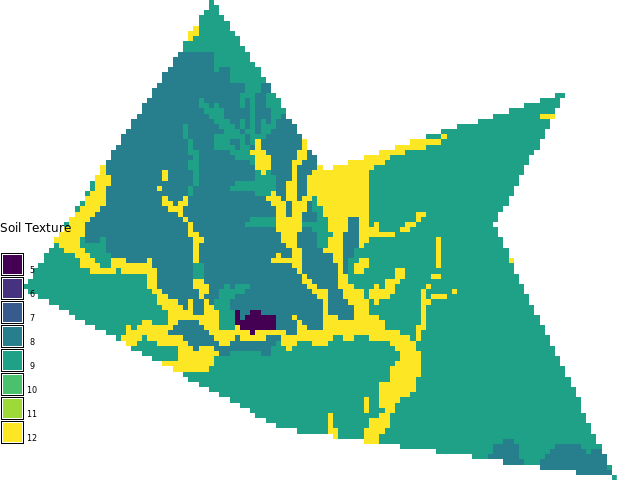

In [41]:
os.environ['GRASS_RENDER_FILE'] = 'soil_texture.png'
!grass78 {LOCATION}/{MAPSET} --exec d.rast map="soil_texture"
!grass78 {LOCATION}/{MAPSET} --exec d.legend raster="soil_texture" fontsize='8' title='Soil Texture' title_fontsize='12' at=5,50,0,5
shutil.copy(os.path.join(CURRENT_DIRECTORY,'soil_texture.png'), os.path.join(PROJECT_DIR,'image_map'))
os.remove('soil_texture.png')
image = os.path.join(PROJECT_DIR,'image_map','soil_texture.png')
Image(filename=image)

## Output SSURGO MUKEY ASCII Raster

> #### `r.out.ascii` to export raster map to a GRASS ASCII raster representation

In [42]:
!grass78 {LOCATION}/{MAPSET} --exec r.out.ascii --overwrite input="ssurgo" output={MODEL_RAST_DIR}/ssurgo.txt -i

Starting GRASS GIS...
Cleaning up temporary files...
Executing <r.out.ascii --overwrite input=ssurgo output=/home/teaganbaiotto/Documents/bbgci/Test/model/raster_inputs/ssurgo.txt -i> ...
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  43  46  49  52  55  58  61  64  67  70  73  76  79  82  86  89  92  95  98Execution of <r.out.ascii --overwrite input=ssurgo output=/home/teaganbaiotto/Documents/bbgci/Test/model/raster_inputs/ssurgo.txt -i> finished.
Cleaning up default sqlite database ...
Cleaning up temporary files...


In [43]:
!grass78 {LOCATION}/{MAPSET} --exec r.out.ascii --overwrite input="soil_texture" output={MODEL_RAST_DIR}/soil_texture.txt -i

Starting GRASS GIS...
Cleaning up temporary files...
Executing <r.out.ascii --overwrite input=soil_texture output=/home/teaganbaiotto/Documents/bbgci/Test/model/raster_inputs/soil_texture.txt -i> ...
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  43  46  49  52  55  58  61  64  67  70  73  76  79  82  86  89  92  95  98Execution of <r.out.ascii --overwrite input=soil_texture output=/home/teaganbaiotto/Documents/bbgci/Test/model/raster_inputs/soil_texture.txt -i> finished.
Cleaning up default sqlite database ...
Cleaning up temporary files...


## Extract LandCover Classification for the watershed

> #### `r.in.gdal` to import raster data into GRASS landuse location using GDAL library.

In [44]:
# Create path for land use if does not exist
lulcRAW = "lulcRAW"
LOCATIONLULC = GISDBASE+'/'+"lulcRAW"
if os.path.exists(os.path.join(GISDBASE, lulcRAW)):
    shutil.rmtree(os.path.join(GISDBASE, lulcRAW))
!grass78 {LOCATION}/{MAPSET} --exec r.in.gdal -o --overwrite input={landcover} output=nlcd location={lulcRAW}

Starting GRASS GIS...
Cleaning up temporary files...
Executing <r.in.gdal -o --overwrite input=/home/teaganbaiotto/Documents/bbgci/Test/gis_data/nlcd_reprojected.tif output=nlcd location=lulcRAW> ...
Location <lulcRAW> created
Importing raster map <nlcd>...
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100
Execution of <r.in.gdal -o --overwrite input=/home/teaganbaiotto/Documents/bbgci/Test/gis_data/nlcd_reprojected.tif output=nlcd location=lulcRAW> finished.
Cleaning up default sqlite database ...
Cleaning up temporary files...


> #### `r.out.gdal` to export raster map and prepare for import into primary GRASS directory

In [45]:
!grass78 {LOCATIONLULC}/{MAPSET} --exec r.out.gdal --overwrite input=nlcd output='nlcd.tif' format=GTiff

Starting GRASS GIS...
Cleaning up temporary files...
Executing <r.out.gdal --overwrite input=nlcd output=nlcd.tif format=GTiff> ...
Checking GDAL data type and nodata value...
   2   5   8  11  14  17  20  23  26  29  32  35  38  41  44  47  50  53  56  59  62  65  68  71  74  77  80  83  86  89  92  95  98 100
Using GDAL data type <Byte>
Input raster map contains cells with NULL-value (no-data). The value 255
will be used to represent no-data values in the input map. You can specify
a nodata value with the nodata option.
Exporting raster data to GTiff format...
   2   5   8  11  14  17  20  23  26  29  32  35  38  41  44  47  50  53  56  59  62  65  68  71  74  77  80  83  86  89  92  95  98 100
r.out.gdal complete. File <nlcd.tif> created.
Execution of <r.out.gdal --overwrite input=nlcd output=nlcd.tif format=GTiff> finished.
Cleaning up temporary files...


> #### `r.in.gdal` to load ssurgo into main GRASS location

In [46]:
!grass78 {LOCATION}/{MAPSET} --exec r.in.gdal -o -e --overwrite input='nlcd.tif' output=nlcd

Starting GRASS GIS...
Cleaning up temporary files...
Executing <r.in.gdal -o -e --overwrite input=nlcd.tif output=nlcd> ...
Over-riding projection check
Importing raster map <nlcd>...
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100
Default region for this location updated
Region for the current mapset updated
Execution of <r.in.gdal -o -e --overwrite input=nlcd.tif output=nlcd> finished.
Cleaning up default sqlite database ...
Cleaning up temporary files...


> #### `g.region` to manage region definitions (extent, cellsize, etc.)

In [47]:
!grass78 {LOCATION}/{MAPSET} --exec g.region region=grass_region -p

Starting GRASS GIS...
Cleaning up temporary files...
Executing <g.region region=grass_region -p> ...
projection: 99 (Lambert_Conformal_Conic)
zone:       0
datum:      ** unknown (default: WGS84) **
ellipsoid:  wgs84
north:      -146970
south:      -149760
west:       1799100
east:       1802550
nsres:      30
ewres:      30
rows:       93
cols:       115
cells:      10695
Execution of <g.region region=grass_region -p> finished.
Cleaning up default sqlite database ...
Cleaning up temporary files...


## Output NLCD ASCII Raster

<div class="alert alert-block alert-info">
<b>Map:</b> Land Use </div>

Starting GRASS GIS...
Cleaning up temporary files...
Executing <d.rast map=nlcd> ...
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  43  46  49  52  55  58  61  64  67  70  73  76  79  82  86  89  92  95  98 100
Execution of <d.rast map=nlcd> finished.
Cleaning up default sqlite database ...
Cleaning up temporary files...
Starting GRASS GIS...
Cleaning up temporary files...
Executing <d.legend raster=nlcd fontsize=8 title=NLCD title_fontsize=12 at=5,50,0,5> ...
Execution of <d.legend raster=nlcd fontsize=8 title=NLCD title_fontsize=12 at=5,50,0,5> finished.
Cleaning up default sqlite database ...
Cleaning up temporary files...


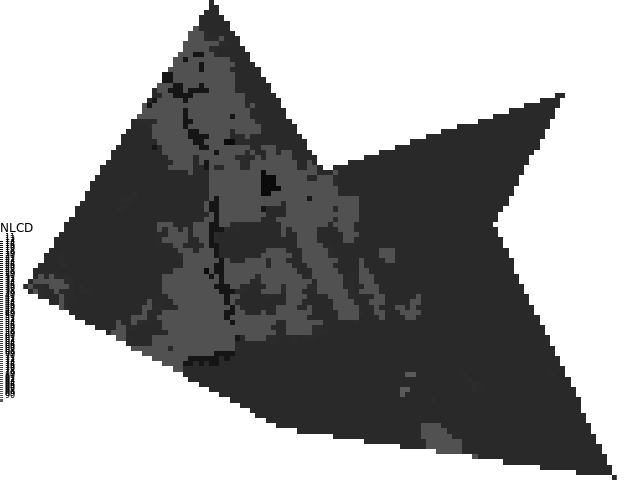

In [48]:
os.environ['GRASS_RENDER_FILE'] = 'nlcd.png'
!grass78 {LOCATION}/{MAPSET} --exec d.rast map="nlcd"
!grass78 {LOCATION}/{MAPSET} --exec d.legend raster="nlcd" fontsize='8' title='NLCD' title_fontsize='12' at=5,50,0,5
shutil.copy(os.path.join(CURRENT_DIRECTORY,'nlcd.png'), os.path.join(PROJECT_DIR,'image_map'))
os.remove('nlcd.png')
image = os.path.join(PROJECT_DIR,'image_map','nlcd.png')
Image(filename=image)

> #### `r.out.ascii` to export a raster map to a GRASS ASCII raster representation

In [49]:
!grass78 {LOCATION}/{MAPSET} --exec r.out.ascii --overwrite input="nlcd" output={MODEL_RAST_DIR}/nlcd.txt -i

Starting GRASS GIS...
Cleaning up temporary files...
Executing <r.out.ascii --overwrite input=nlcd output=/home/teaganbaiotto/Documents/bbgci/Test/model/raster_inputs/nlcd.txt -i> ...
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  43  46  49  52  55  58  61  64  67  70  73  76  79  82  86  89  92  95  98Execution of <r.out.ascii --overwrite input=nlcd output=/home/teaganbaiotto/Documents/bbgci/Test/model/raster_inputs/nlcd.txt -i> finished.
Cleaning up default sqlite database ...
Cleaning up temporary files...


## Output LAT/LONG ASCII Raster

> #### `g.region` to manage region definitions (extent, cellsize, etc.)

In [50]:
!grass78 {LOCATION}/{MAPSET} --exec g.region region=grass_region -p

Starting GRASS GIS...
Cleaning up temporary files...
Executing <g.region region=grass_region -p> ...
projection: 99 (Lambert_Conformal_Conic)
zone:       0
datum:      ** unknown (default: WGS84) **
ellipsoid:  wgs84
north:      -146970
south:      -149760
west:       1799100
east:       1802550
nsres:      30
ewres:      30
rows:       93
cols:       115
cells:      10695
Execution of <g.region region=grass_region -p> finished.
Cleaning up default sqlite database ...
Cleaning up temporary files...


> #### `r.mapcalc` creates raster map corresponding to provided expression. In this case, maps corresponding to latitude and longitude are generated

In [51]:
!grass78 {LOCATION}/{MAPSET} --exec r.mapcalc --overwrite expression="xmap = x()"
!grass78 {LOCATION}/{MAPSET} --exec r.mapcalc --overwrite expression="ymap = y()"

Starting GRASS GIS...
Cleaning up temporary files...
Executing <r.mapcalc --overwrite expression=xmap = x()> ...
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  43  46  49  52  55  58  61  64  67  70  73  76  79  82  86  89  92  95  98 100
Execution of <r.mapcalc --overwrite expression=xmap = x()> finished.
Cleaning up default sqlite database ...
Cleaning up temporary files...
Starting GRASS GIS...
Cleaning up temporary files...
Executing <r.mapcalc --overwrite expression=ymap = y()> ...
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  43  46  49  52  55  58  61  64  67  70  73  76  79  82  86  89  92  95  98 100
Execution of <r.mapcalc --overwrite expression=ymap = y()> finished.
Cleaning up default sqlite database ...
Cleaning up temporary files...


<div class="alert alert-block alert-info">
<b>Map:</b> Longitude </div>

Starting GRASS GIS...
Cleaning up temporary files...
Executing <d.rast map=xmap> ...
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  43  46  49  52  55  58  61  64  67  70  73  76  79  82  86  89  92  95  98 100
Execution of <d.rast map=xmap> finished.
Cleaning up default sqlite database ...
Cleaning up temporary files...
Starting GRASS GIS...
Cleaning up temporary files...
Executing <d.legend raster=xmap fontsize=8 title=xmap title_fontsize=12 at=5,50,0,5> ...
Execution of <d.legend raster=xmap fontsize=8 title=xmap title_fontsize=12 at=5,50,0,5> finished.
Cleaning up default sqlite database ...
Cleaning up temporary files...


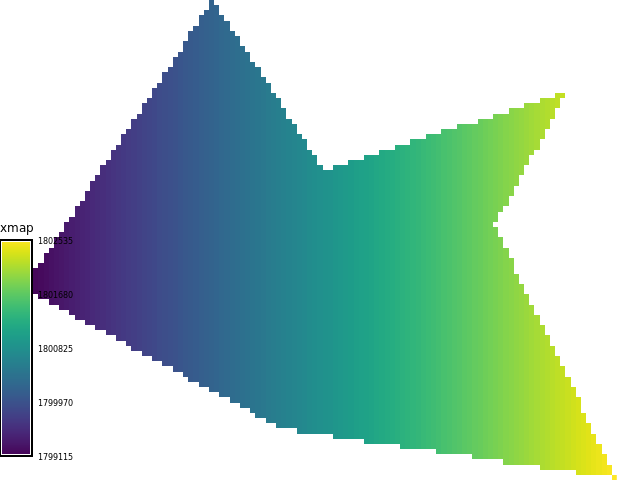

In [52]:
os.environ['GRASS_RENDER_FILE'] = 'xmap.png'
!grass78 {LOCATION}/{MAPSET} --exec d.rast map="xmap"
!grass78 {LOCATION}/{MAPSET} --exec d.legend raster="xmap" fontsize='8' title='xmap' title_fontsize='12' at=5,50,0,5
shutil.copy(os.path.join(CURRENT_DIRECTORY,'xmap.png'), os.path.join(PROJECT_DIR,'image_map'))
os.remove('xmap.png')
image = os.path.join(PROJECT_DIR,'image_map','xmap.png')
Image(filename=image)

> #### `r.out.ascii` to export a raster map to a GRASS ASCII raster representation

In [53]:
!grass78 {LOCATION}/{MAPSET} --exec r.out.ascii --overwrite input="xmap" output={MODEL_RAST_DIR}/xmap.txt -i

Starting GRASS GIS...
Cleaning up temporary files...
Executing <r.out.ascii --overwrite input=xmap output=/home/teaganbaiotto/Documents/bbgci/Test/model/raster_inputs/xmap.txt -i> ...
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  43  46  49  52  55  58  61  64  67  70  73  76  79  82  86  89  92  95  98Execution of <r.out.ascii --overwrite input=xmap output=/home/teaganbaiotto/Documents/bbgci/Test/model/raster_inputs/xmap.txt -i> finished.
Cleaning up default sqlite database ...
Cleaning up temporary files...


<div class="alert alert-block alert-info">
<b>Map:</b> Latitude </div>

Starting GRASS GIS...
Cleaning up temporary files...
Executing <d.rast map=ymap> ...
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  43  46  49  52  55  58  61  64  67  70  73  76  79  82  86  89  92  95  98 100
Execution of <d.rast map=ymap> finished.
Cleaning up default sqlite database ...
Cleaning up temporary files...
Starting GRASS GIS...
Cleaning up temporary files...
Executing <d.legend raster=ymap fontsize=8 title=ymap title_fontsize=12 at=5,50,0,5> ...
Execution of <d.legend raster=ymap fontsize=8 title=ymap title_fontsize=12 at=5,50,0,5> finished.
Cleaning up default sqlite database ...
Cleaning up temporary files...


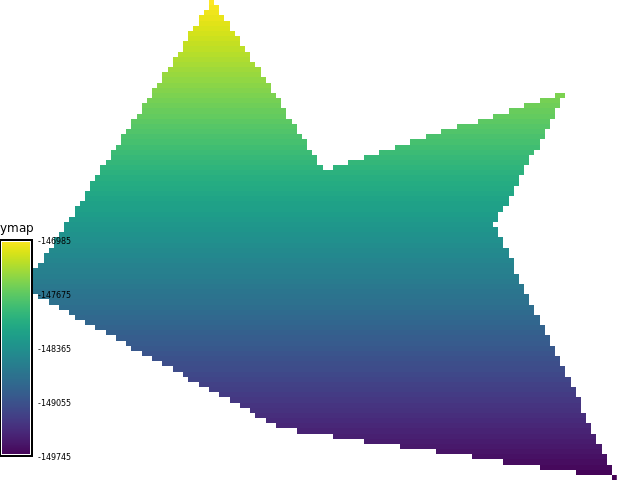

In [54]:
os.environ['GRASS_RENDER_FILE'] = 'ymap.png'
!grass78 {LOCATION}/{MAPSET} --exec d.rast map="ymap"
!grass78 {LOCATION}/{MAPSET} --exec d.legend raster="ymap" fontsize='8' title='ymap' title_fontsize='12' at=5,50,0,5
shutil.copy(os.path.join(CURRENT_DIRECTORY,'ymap.png'), os.path.join(PROJECT_DIR,'image_map'))
os.remove('ymap.png')
image = os.path.join(PROJECT_DIR,'image_map','ymap.png')
Image(filename=image)

> #### `r.out.ascii` to export a raster map to a GRASS ASCII raster representation

In [55]:
!grass78 {LOCATION}/{MAPSET} --exec r.out.ascii --overwrite input="ymap" output={MODEL_RAST_DIR}/ymap.txt -i

Starting GRASS GIS...
Cleaning up temporary files...
Executing <r.out.ascii --overwrite input=ymap output=/home/teaganbaiotto/Documents/bbgci/Test/model/raster_inputs/ymap.txt -i> ...
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  43  46  49  52  55  58  61  64  67  70  73  76  79  82  86  89  92  95  98Execution of <r.out.ascii --overwrite input=ymap output=/home/teaganbaiotto/Documents/bbgci/Test/model/raster_inputs/ymap.txt -i> finished.
Cleaning up default sqlite database ...
Cleaning up temporary files...


## Output Daymet Cell Re-Positioning ASCII Rasters

> #### `r.in.gdal` to import raster data into custom GRASS daymet location using GDAL library.

In [56]:
# Create path for daymet data if does not exist
daymet = "daymet"
LOCATIONDAYMET = GISDBASE+'/'+"daymet"
if os.path.exists(os.path.join(GISDBASE, daymet)):
    shutil.rmtree(os.path.join(GISDBASE, daymet))
!grass78 {LOCATION}/{MAPSET} --exec r.in.gdal -o --overwrite input={daymet_cell} output=daymet location={daymet}

Starting GRASS GIS...
Cleaning up temporary files...
Executing <r.in.gdal -o --overwrite input=/home/teaganbaiotto/Documents/bbgci/Test/gis_data/daymet_cell.tif output=daymet location=daymet> ...
Location <daymet> created
Importing raster map <daymet>...
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100
Execution of <r.in.gdal -o --overwrite input=/home/teaganbaiotto/Documents/bbgci/Test/gis_data/daymet_cell.tif output=daymet location=daymet> finished.
Cleaning up default sqlite database ...
Cleaning up temporary files...


> #### `r.out.gdal` to export raster map and prepare for import into primary GRASS directory

In [57]:
!grass78 {LOCATIONDAYMET}/{MAPSET} --exec r.out.gdal --overwrite input=daymet output='daymet.tif' format=GTiff

Starting GRASS GIS...
Cleaning up temporary files...
Executing <r.out.gdal --overwrite input=daymet output=daymet.tif format=GTiff> ...
Checking GDAL data type and nodata value...
   2   5   8  11  14  17  20  23  26  29  32  35  38  41  44  47  50  53  56  59  62  65  68  71  74  77  80  83  86  89  92  95  98 100
Using GDAL data type <Float64>
Input raster map contains cells with NULL-value (no-data). The value -nan
will be used to represent no-data values in the input map. You can specify
a nodata value with the nodata option.
Exporting raster data to GTiff format...
ERROR 6: SetColorTable() only supported for Byte or UInt16 bands in TIFF format.
   2   5   8  11  14  17  20  23  26  29  32  35  38  41  44  47  50  53  56  59  62  65  68  71  74  77  80  83  86  89  92  95  98 100
r.out.gdal complete. File <daymet.tif> created.
Execution of <r.out.gdal --overwrite input=daymet output=daymet.tif format=GTiff> finished.
Cleaning up temporary files...


> #### `r.in.gdal` to load ssurgo into main GRASS location

In [58]:
!grass78 {LOCATION}/{MAPSET} --exec r.in.gdal -o -e --overwrite input='daymet.tif' output=daymet

Starting GRASS GIS...
Cleaning up temporary files...
Executing <r.in.gdal -o -e --overwrite input=daymet.tif output=daymet> ...
Over-riding projection check
Importing raster map <daymet>...
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100
Default region for this location updated
Region for the current mapset updated
Execution of <r.in.gdal -o -e --overwrite input=daymet.tif output=daymet> finished.
Cleaning up default sqlite database ...
Cleaning up temporary files...


> #### `g.region` to manage region definitions (extent, cellsize, etc.)

In [59]:
!grass78 {LOCATION}/{MAPSET} --exec g.region region=grass_region -ap

Starting GRASS GIS...
Cleaning up temporary files...
Executing <g.region region=grass_region -ap> ...
projection: 99 (Lambert_Conformal_Conic)
zone:       0
datum:      ** unknown (default: WGS84) **
ellipsoid:  wgs84
north:      -146970
south:      -149760
west:       1799100
east:       1802550
nsres:      30
ewres:      30
rows:       93
cols:       115
cells:      10695
Execution of <g.region region=grass_region -ap> finished.
Cleaning up default sqlite database ...
Cleaning up temporary files...


<div class="alert alert-block alert-info">
<b>Map:</b> Daymet Cell Identifier </div>

Starting GRASS GIS...
Cleaning up temporary files...
Executing <d.rast map=daymet> ...
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  43  46  49  52  55  58  61  64  67  70  73  76  79  82  86  89  92  95  98 100
Execution of <d.rast map=daymet> finished.
Cleaning up default sqlite database ...
Cleaning up temporary files...
Starting GRASS GIS...
Cleaning up temporary files...
Executing <d.legend raster=daymet fontsize=8 title=Daymet title_fontsize=12 at=5,50,0,5> ...
Execution of <d.legend raster=daymet fontsize=8 title=Daymet title_fontsize=12 at=5,50,0,5> finished.
Cleaning up default sqlite database ...
Cleaning up temporary files...


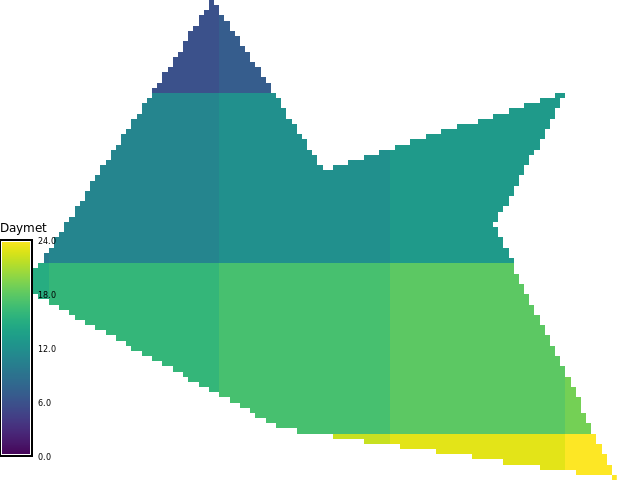

In [60]:
os.environ['GRASS_RENDER_FILE'] = 'daymet.png'
!grass78 {LOCATION}/{MAPSET} --exec d.rast map="daymet"
!grass78 {LOCATION}/{MAPSET} --exec d.legend raster="daymet" fontsize='8' title='Daymet' title_fontsize='12' at=5,50,0,5
shutil.copy(os.path.join(CURRENT_DIRECTORY,'daymet.png'), os.path.join(PROJECT_DIR,'image_map'))
os.remove('daymet.png')
image = os.path.join(PROJECT_DIR,'image_map','daymet.png')
Image(filename=image)

> #### `r.out.ascii` to export a raster map to a GRASS ASCII raster representation

In [61]:
!grass78 {LOCATION}/{MAPSET} --exec r.out.ascii --overwrite input="daymet" output={MODEL_RAST_DIR}/daymet.txt -i

Starting GRASS GIS...
Cleaning up temporary files...
Executing <r.out.ascii --overwrite input=daymet output=/home/teaganbaiotto/Documents/bbgci/Test/model/raster_inputs/daymet.txt -i> ...
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  43  46  49  52  55  58  61  64  67  70  73  76  79  82  86  89  92  95  98Execution of <r.out.ascii --overwrite input=daymet output=/home/teaganbaiotto/Documents/bbgci/Test/model/raster_inputs/daymet.txt -i> finished.
Cleaning up default sqlite database ...
Cleaning up temporary files...
